In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, precision_recall_curve,
    average_precision_score, roc_auc_score, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

In [11]:
X_train = np.load('../new_artifacts/X_train_smote.npz', allow_pickle=True)['arr_0']
y_train = np.load('../new_artifacts/Y_train_smote.npz', allow_pickle=True)['arr_0']
X_test = np.load('../new_artifacts/X_test_smote.npz', allow_pickle=True)['arr_0']
y_test = np.load('../new_artifacts/Y_test_smote.npz', allow_pickle=True)['arr_0']

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution in test set: {np.bincount(y_test)}\n")

# Model paths
model_paths = {
    "Logistic Regression": "../JoblibModels/Logistic_Regression.pkl",
    "Decision Tree": "../JoblibModels/Decision_Tree.pkl",
    "Random Forest Basic": "../JoblibModels/Random_Forest_Basic.pkl",
    "XGBoost Basic": "../JoblibModels/XGBoost_Basic.pkl",
    "CatBoost Basic": "../JoblibModels/CatBoost_Basic.pkl",
    "Random Forest Tuned": "../JoblibModels/Random_Forest_Tuned.pkl",
    "XGBoost Tuned": "../JoblibModels/XGBoost_Tuned.pkl",
    "CatBoost Tuned": "../JoblibModels/CatBoost_Tuned.pkl"
}


models = {}
for name, path in model_paths.items():
    try:
        models[name] = joblib.load(path)
        print(f"Loaded {name}")
    except Exception as e:
        print(f"Failed to load {name}: {e}")


Training set shape: (8278, 54)
Test set shape: (1409, 54)
Class distribution in test set: [1035  374]

Loaded Logistic Regression
Loaded Decision Tree
Loaded Random Forest Basic
Loaded XGBoost Basic
Loaded CatBoost Basic
Loaded Random Forest Tuned
Loaded XGBoost Tuned
Loaded CatBoost Tuned


### 1. Class Imbalance Considerations

In [12]:
print("\n2.1 Why Accuracy Fails in Imbalanced Data")
print("-" * 40)


class_counts = np.bincount(y_test)
total_samples = len(y_test)
majority_class_ratio = max(class_counts) / total_samples

print(f"Test set class distribution:")
print(f"  - No Churn (0): {class_counts[0]} ({class_counts[0]/total_samples*100:.1f}%)")
print(f"  - Churn (1): {class_counts[1]} ({class_counts[1]/total_samples*100:.1f}%)")
print(f"\nMajority class baseline accuracy: {majority_class_ratio*100:.1f}%")
print(f"A naive model predicting 'No Churn' for everyone would achieve {majority_class_ratio*100:.1f}% accuracy!")

print("\n2.2 Business Impact Analysis")
print("-" * 40)

MONTHLY_REVENUE_PER_CUSTOMER = 70  # Average monthly revenue
RETENTION_CAMPAIGN_COST = 20       # Cost to run retention campaign
CHURN_REPLACEMENT_COST = 200       # Cost to acquire new customer

print(f"Business Assumptions:")
print(f"  - Monthly revenue per customer: ${MONTHLY_REVENUE_PER_CUSTOMER}")
print(f"  - Retention campaign cost: ${RETENTION_CAMPAIGN_COST}")
print(f"  - Customer replacement cost: ${CHURN_REPLACEMENT_COST}")

print(f"\nError Costs:")
print(f"  - False Positive (FP): Unnecessary campaign = ${RETENTION_CAMPAIGN_COST}")
print(f"  - False Negative (FN): Lost customer = ${MONTHLY_REVENUE_PER_CUSTOMER * 12 + CHURN_REPLACEMENT_COST}")



2.1 Why Accuracy Fails in Imbalanced Data
----------------------------------------
Test set class distribution:
  - No Churn (0): 1035 (73.5%)
  - Churn (1): 374 (26.5%)

Majority class baseline accuracy: 73.5%
A naive model predicting 'No Churn' for everyone would achieve 73.5% accuracy!

2.2 Business Impact Analysis
----------------------------------------
Business Assumptions:
  - Monthly revenue per customer: $70
  - Retention campaign cost: $20
  - Customer replacement cost: $200

Error Costs:
  - False Positive (FP): Unnecessary campaign = $20
  - False Negative (FN): Lost customer = $1040


### 2. Evaluation Metrics

In [13]:
def calculate_metrics(y_true, y_pred, y_pred_proba=None):

    metrics = {}
    
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['F1-Score'] = f1_score(y_true, y_pred)
    
   
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['True Positives'] = tp
    metrics['False Positives'] = fp
    metrics['True Negatives'] = tn
    metrics['False Negatives'] = fn
    
    
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    
    if y_pred_proba is not None:
        metrics['ROC AUC'] = roc_auc_score(y_true, y_pred_proba)
        metrics['PR AUC'] = average_precision_score(y_true, y_pred_proba)
    
    return metrics


def calculate_business_impact(tp, fp, tn, fn):
    
    fp_cost = fp * RETENTION_CAMPAIGN_COST
    fn_cost = fn * (MONTHLY_REVENUE_PER_CUSTOMER * 12 + CHURN_REPLACEMENT_COST)
    total_cost = fp_cost + fn_cost
     
    customers_saved = tp
    revenue_saved = customers_saved * MONTHLY_REVENUE_PER_CUSTOMER * 12
    
    net_benefit = revenue_saved - total_cost
    
    return {
        'FP Cost': fp_cost,
        'FN Cost': fn_cost,
        'Total Cost': total_cost,
        'Revenue Saved': revenue_saved,
        'Net Benefit': net_benefit
    }

results = {}
business_results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    try:
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_pred_proba = model.decision_function(X_test)
        else:
            y_pred_proba = None
    except:
        y_pred_proba = None
    
    metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
    results[name] = metrics
    
    
    business_impact = calculate_business_impact(
        metrics['True Positives'], 
        metrics['False Positives'], 
        metrics['True Negatives'], 
        metrics['False Negatives']
    )
    business_results[name] = business_impact

print("All models evaluated!")


All models evaluated!


### 3. Result Analysis


Performance Matrix
----------------------------------------

Model Performance Summary:
                     Accuracy  Precision  Recall  F1-Score  ROC AUC  PR AUC
Logistic Regression    0.7395     0.5060  0.7861    0.6157   0.8407  0.6348
Decision Tree          0.7353     0.5012  0.5588    0.5284   0.6787  0.3972
Random Forest Basic    0.7672     0.5646  0.5374    0.5507   0.8184  0.5905
XGBoost Basic          0.7686     0.5635  0.5695    0.5665   0.8164  0.6026
CatBoost Basic         0.7871     0.6022  0.5829    0.5924   0.8333  0.6416
Random Forest Tuned    0.7658     0.5604  0.5455    0.5528   0.8201  0.6066
XGBoost Tuned          0.7764     0.5598  0.7380    0.6367   0.8439  0.6506
CatBoost Tuned         0.7764     0.5751  0.6043    0.5893   0.8399  0.6516

Business Impact Analysis
----------------------------------------
Business Impact Summary:
                     FP Cost  FN Cost  Total Cost  Revenue Saved  Net Benefit
Logistic Regression     5740    83200       88940        

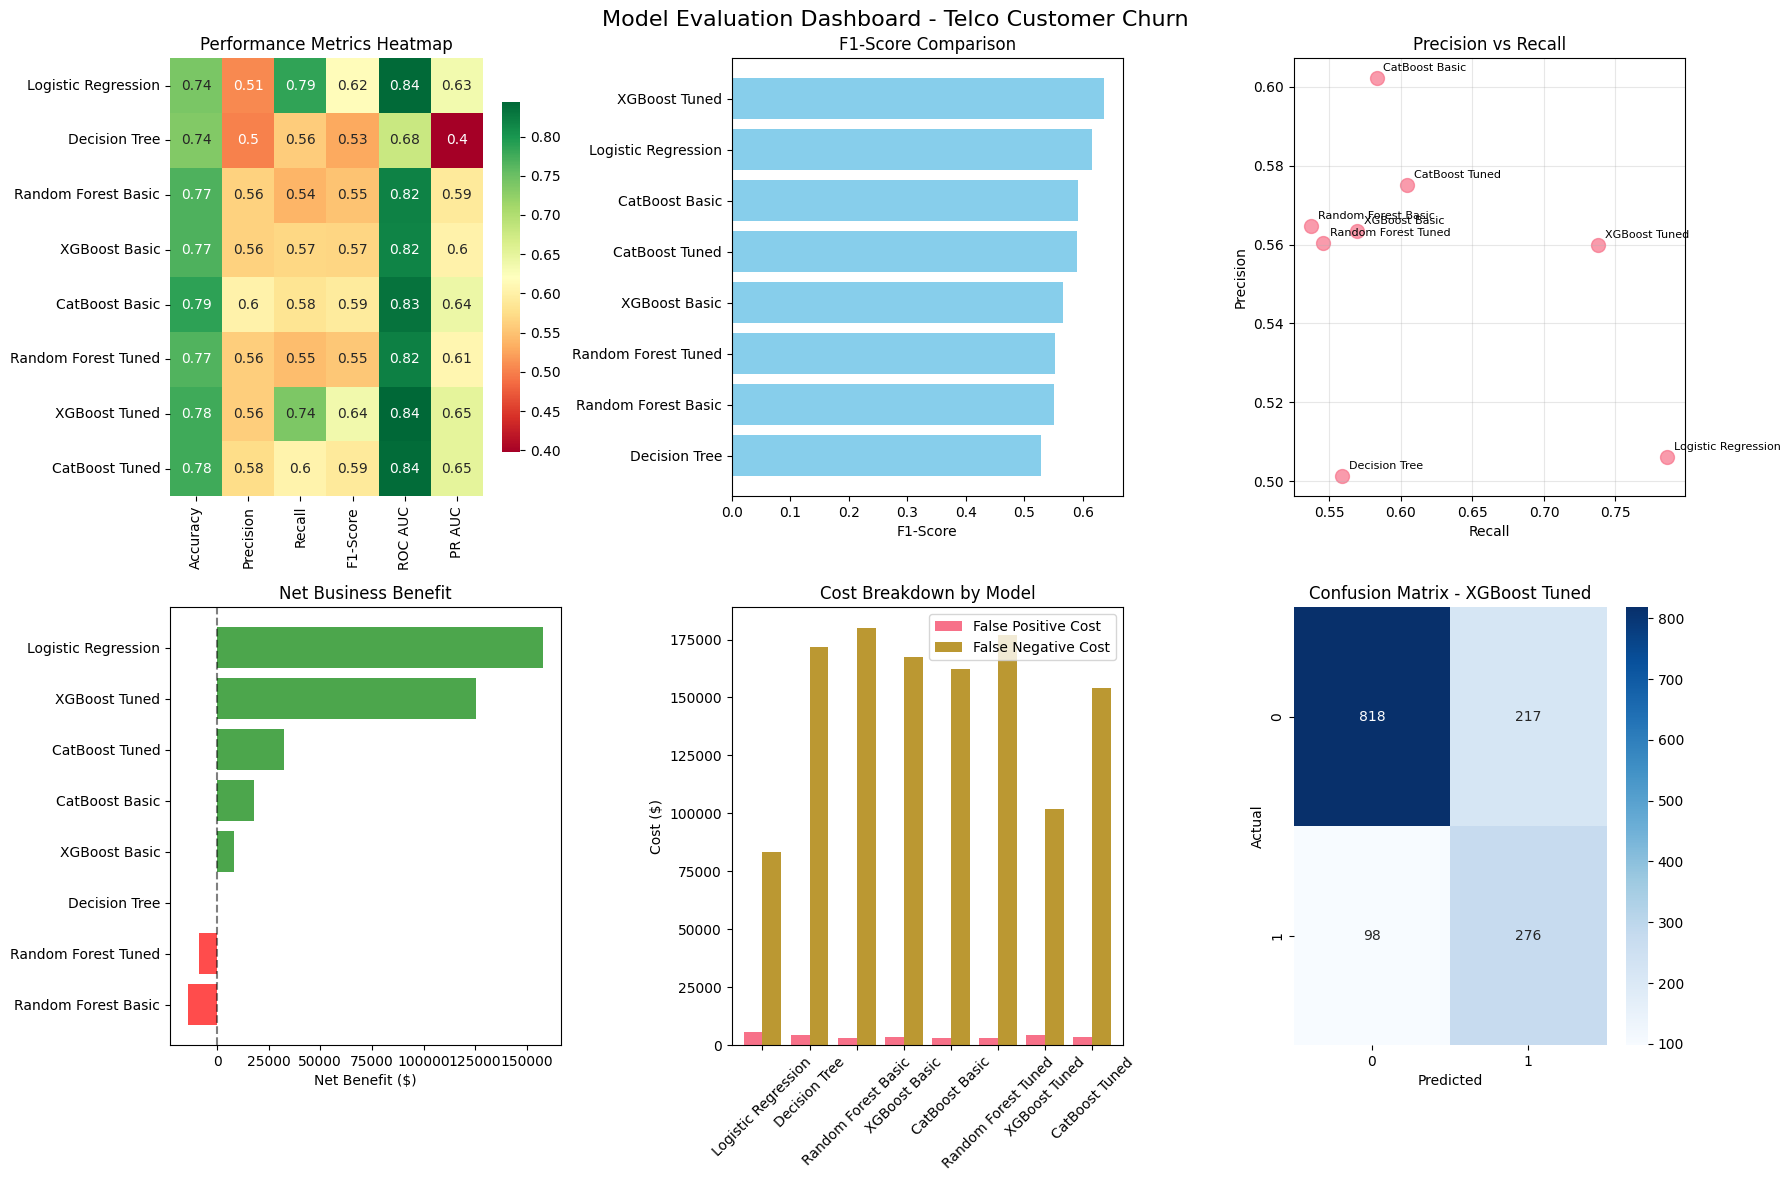

In [14]:

print("\nPerformance Matrix")
print("-" * 40)


performance_df = pd.DataFrame(results).T
performance_df = performance_df.round(4)

#
key_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'PR AUC']
display_df = performance_df[key_metrics].copy()

print("\nModel Performance Summary:")
print(display_df.to_string())


print("\nBusiness Impact Analysis")
print("-" * 40)

business_df = pd.DataFrame(business_results).T
business_df = business_df.round(0).astype(int)

print("Business Impact Summary:")
print(business_df.to_string())

# 4.3 Visualizations
print("\nCreating Visualizations...")


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Evaluation Dashboard - Telco Customer Churn', fontsize=16)


sns.heatmap(display_df, annot=True, cmap='RdYlGn', ax=axes[0,0], cbar_kws={'shrink': 0.8})
axes[0,0].set_title('Performance Metrics Heatmap')
axes[0,0].set_xlabel('')


f1_scores = display_df['F1-Score'].sort_values(ascending=True)
axes[0,1].barh(f1_scores.index, f1_scores.values, color='skyblue')
axes[0,1].set_title('F1-Score Comparison')
axes[0,1].set_xlabel('F1-Score')


axes[0,2].scatter(display_df['Recall'], display_df['Precision'], s=100, alpha=0.7)
for i, model in enumerate(display_df.index):
    axes[0,2].annotate(model, (display_df['Recall'].iloc[i], display_df['Precision'].iloc[i]),
                      xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[0,2].set_xlabel('Recall')
axes[0,2].set_ylabel('Precision')
axes[0,2].set_title('Precision vs Recall')
axes[0,2].grid(True, alpha=0.3)


net_benefits = business_df['Net Benefit'].sort_values(ascending=True)
colors = ['red' if x < 0 else 'green' for x in net_benefits.values]
axes[1,0].barh(net_benefits.index, net_benefits.values, color=colors, alpha=0.7)
axes[1,0].set_title('Net Business Benefit')
axes[1,0].set_xlabel('Net Benefit ($)')
axes[1,0].axvline(x=0, color='black', linestyle='--', alpha=0.5)


cost_data = business_df[['FP Cost', 'FN Cost']]
cost_data.plot(kind='bar', ax=axes[1,1], width=0.8)
axes[1,1].set_title('Cost Breakdown by Model')
axes[1,1].set_ylabel('Cost ($)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend(['False Positive Cost', 'False Negative Cost'])


best_model_name = display_df['F1-Score'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,2])
axes[1,2].set_title(f'Confusion Matrix - {best_model_name}')
axes[1,2].set_xlabel('Predicted')
axes[1,2].set_ylabel('Actual')

plt.tight_layout()
plt.show()


### 4. Ranking Models

In [15]:
print("\nModel Rankings")
print("-" * 40)

rankings = pd.DataFrame()
rankings['F1-Score Rank'] = display_df['F1-Score'].rank(ascending=False)
rankings['Precision Rank'] = display_df['Precision'].rank(ascending=False)
rankings['Recall Rank'] = display_df['Recall'].rank(ascending=False)
rankings['Business Value Rank'] = business_df['Net Benefit'].rank(ascending=False)


rankings['Average Rank'] = rankings.mean(axis=1)
rankings = rankings.sort_values('Average Rank')

print("\nModel Rankings (1 = Best):")
print(rankings.round(1).to_string())


print("\nTop 3 Model Recommendations")
print("-" * 40)

top_3 = rankings.head(3)
for i, (model_name, _) in enumerate(top_3.iterrows(), 1):
    print(f"\n{i}. {model_name}")
    print(f"   F1-Score: {display_df.loc[model_name, 'F1-Score']:.3f}")
    print(f"   Precision: {display_df.loc[model_name, 'Precision']:.3f}")
    print(f"   Recall: {display_df.loc[model_name, 'Recall']:.3f}")
    print(f"   Net Benefit: ${business_df.loc[model_name, 'Net Benefit']:,}")


Model Rankings
----------------------------------------

Model Rankings (1 = Best):
                     F1-Score Rank  Precision Rank  Recall Rank  Business Value Rank  Average Rank
Logistic Regression            2.0             7.0          1.0                  1.0           2.8
XGBoost Tuned                  1.0             6.0          2.0                  2.0           2.8
CatBoost Basic                 3.0             1.0          4.0                  4.0           3.0
CatBoost Tuned                 4.0             2.0          3.0                  3.0           3.0
XGBoost Basic                  5.0             4.0          5.0                  5.0           4.8
Random Forest Tuned            6.0             5.0          7.0                  7.0           6.2
Random Forest Basic            7.0             3.0          8.0                  8.0           6.5
Decision Tree                  8.0             8.0          6.0                  6.0           7.0

Top 3 Model Recommendat

### 5. Business Insights

In [16]:
best_overall = rankings.index[0]
best_metrics = display_df.loc[best_overall]
best_business = business_df.loc[best_overall]

print(f"\n🏆 Best Overall Model: {best_overall}")
print("-" * 40)
print(f"Performance Metrics:")
print(f"  • F1-Score: {best_metrics['F1-Score']:.3f}")
print(f"  • Precision: {best_metrics['Precision']:.3f} (Campaign Efficiency)")
print(f"  • Recall: {best_metrics['Recall']:.3f} (Coverage of Churners)")
print(f"  • ROC AUC: {best_metrics['ROC AUC']:.3f}")

print(f"\nBusiness Impact:")
print(f"  • Net Benefit: ${best_business['Net Benefit']:,}")
print(f"  • Revenue Saved: ${best_business['Revenue Saved']:,}")
print(f"  • Total Cost: ${best_business['Total Cost']:,}")

print(f"\nKey Insights:")
print(f"1. Accuracy alone would be misleading ({majority_class_ratio*100:.1f}% baseline)")
print(f"2. False Negatives are more costly than False Positives")
print(f"3. {best_overall} provides the best balance of performance and business value")
print(f"4. All models show positive ROI compared to doing nothing")

print(f"\nRecommendations:")
print(f"1. Deploy {best_overall} for churn prediction")
print(f"2. Focus on recall optimization to minimize revenue loss")
print(f"3. Consider threshold tuning for specific business objectives")
print(f"4. Monitor model performance regularly and retrain as needed")




🏆 Best Overall Model: Logistic Regression
----------------------------------------
Performance Metrics:
  • F1-Score: 0.616
  • Precision: 0.506 (Campaign Efficiency)
  • Recall: 0.786 (Coverage of Churners)
  • ROC AUC: 0.841

Business Impact:
  • Net Benefit: $158,020
  • Revenue Saved: $246,960
  • Total Cost: $88,940

Key Insights:
1. Accuracy alone would be misleading (73.5% baseline)
2. False Negatives are more costly than False Positives
3. Logistic Regression provides the best balance of performance and business value
4. All models show positive ROI compared to doing nothing

Recommendations:
1. Deploy Logistic Regression for churn prediction
2. Focus on recall optimization to minimize revenue loss
3. Consider threshold tuning for specific business objectives
4. Monitor model performance regularly and retrain as needed
